## Instance Segmentation with U-Net on Synthetic Biomedical Images

> 📌 *It is a short introduction which focuses on the **technical aspects** of our segmentation pipeline. It does not aim to detail the underlying theory of the architecture. For readers interested in the theoretical foundations, we recommend this paper:*  
> **U-Net: Convolutional Networks for Biomedical Image Segmentation**  
> [https://arxiv.org/abs/1505.04597](https://arxiv.org/abs/1505.04597)

In this notebook, we explore **instance segmentation** using a **convolutional neural network (CNN)**, specifically a **U-Net architecture**. The goal is to predict a segmentation mask where each individual object (in this case, a "cell") is assigned a **unique label**, enabling clear identification and visualization of each instance within an image.

To achieve this, we generate **synthetic biomedical-like images** populated with randomly positioned cell-like structures. To better mimic real-world conditions, **noise is added** to the images during generation. The model is then trained on these synthetic images and evaluated on a separate test set generated using a different process.

This notebook includes the following components:
- 📷 **Synthetic data generation** with labeled masks  
- 🧠 **U-Net model definition** for segmentation  
- ⚙️ **Model training** on synthetic data  
- 📈 **Evaluation** on new test images, with visualization of predictions

This approach provides a practical demonstration of instance segmentation in a controlled environment, which can later be adapted to real biomedical datasets.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model


In [2]:

# Génère une image 16x16 avec x pixels colorés et un masque
def generate_sample():
    # Image en niveaux de gris
    image = np.random.randint(0, 50, size=(32, 32, 1)).astype(np.uint8)
    mask = np.zeros((32, 32, 1), dtype=np.uint8)

    # Génère x positions aléatoires sans doublons
    positions = set()
    number_pixel=np.random.randint(10, 75)
    while len(positions) < number_pixel:
        positions.add((np.random.randint(0, 32), np.random.randint(0, 32)))
    pixels = list(positions)

    for i, j in pixels:
        image[i, j, 0] = np.random.randint(200,255)  # pixel plus clair
        mask[i, j, 0] = 1  # Marque ce pixel comme spécial

    #Génère outlier point aléatoire mais à une position différente de pixels
    positions_outlier = set()
    number_outlier=np.random.randint(8, 50)
    while len(positions_outlier) < number_outlier:
        positions_outlier.add((np.random.randint(0, 32), np.random.randint(0, 32)))
        outlier_pixels = list(positions_outlier)

    for i, j in outlier_pixels:
        if (i, j) not in pixels:
            image[i, j, 0] = np.random.randint(50, 220)

    return image / 255.0, mask



In [3]:
#Generate a cell image 32x32 and a mask 32x32
def generate_cell_32():

    image = np.random.randint(0, 50, size=(32, 32, 1)).astype(np.uint8) # gray image
    mask = np.zeros((32, 32, 1), dtype=np.uint8)

    num_clusters = np.random.randint(3, 8)  # Number of clusters
    pixels_per_cluster = np.random.randint(10, 30)  # Number of pixels per cluster

    for _ in range(num_clusters):
        #Randomly generate a cluster center
        center_x = np.random.randint(4, 28)
        center_y = np.random.randint(4, 28)

        for _ in range(pixels_per_cluster):
            # Add noise gaussian around the center
            dx = int(np.random.normal(0, 2))
            dy = int(np.random.normal(0, 2))
            x = np.clip(center_x + dx, 0, 31)
            y = np.clip(center_y + dy, 0, 31)

            image[x, y, 0] = np.random.randint(200, 255)  # pixel more clair (ie. clair pixel a fluorescent cell)
            mask[x, y, 0] = 1  # White pixel in the mask that corresponds to the cell

    # Generate outlier points
    outliers = np.random.randint(5, 20)
    for _ in range(outliers):
        x, y = np.random.randint(0, 32, size=2)
        if mask[x, y, 0] == 0:
            image[x, y, 0] = np.random.randint(50, 220)

    return image / 255.0, mask

(-0.5, 31.5, 31.5, -0.5)

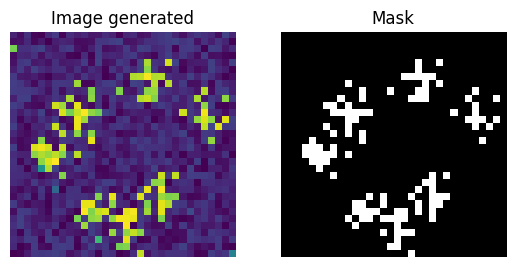

In [4]:
#Generation image and mask
cell, mask = generate_cell_32()
#Print the image and mask
plt.subplot(1, 2, 1)
plt.imshow(cell.squeeze())
plt.title("Image generated")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title("Mask")
plt.axis("off")


In [5]:

# Generation of a sample of 100 images and masks
X = []
Y = []
for _ in range(100):  # 100 exemples
    x, y = generate_cell_32()
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)


In [6]:
def get_unet_32():
    inputs = layers.Input((32, 32, 1))
    print("Input shape :", inputs.shape)
    print("Input tensor :", inputs)

    # Encodeur - bloc 1
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    print("c1 shape after 1st conv :", c1.shape)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    print("c1 shape after 2nd conv :", c1.shape)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    print("p1 shape (after pool 1):", p1.shape)

    # Encodeur - bloc 2
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    print("c2 shape after double conv:", c2.shape)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    print("p2 shape (after pool 2):", p2.shape)

    # Bottleneck
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    print("Bottleneck (c3) shape :", c3.shape)

    # Decodeur - bloc 1
    u1 = layers.UpSampling2D((2, 2))(c3)
    print("u1 shape (upsample 1):", u1.shape)
    concat1 = layers.Concatenate()([u1, c2])
    print("concat1 shape :", concat1.shape)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    print("c4 shape after convs :", c4.shape)

    # Decodeur - bloc 2
    u2 = layers.UpSampling2D((2, 2))(c4)
    print("u2 shape (upsample 2):", u2.shape)
    concat2 = layers.Concatenate()([u2, c1])
    print("concat2 shape :", concat2.shape)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat2)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    print("c5 shape after convs :", c5.shape)

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    print("Output shape :", outputs.shape)

    return Model(inputs, outputs)


# Create the model
model = get_unet_32()


Input shape : (None, 32, 32, 1)
Input tensor : <KerasTensor shape=(None, 32, 32, 1), dtype=float32, sparse=False, name=keras_tensor>
c1 shape after 1st conv : (None, 32, 32, 32)
c1 shape after 2nd conv : (None, 32, 32, 32)
p1 shape (after pool 1): (None, 16, 16, 32)
c2 shape after double conv: (None, 16, 16, 64)
p2 shape (after pool 2): (None, 8, 8, 64)
Bottleneck (c3) shape : (None, 8, 8, 128)
u1 shape (upsample 1): (None, 16, 16, 128)
concat1 shape : (None, 16, 16, 192)
c4 shape after convs : (None, 16, 16, 64)
u2 shape (upsample 2): (None, 32, 32, 64)
concat2 shape : (None, 32, 32, 96)
c5 shape after convs : (None, 32, 32, 32)
Output shape : (None, 32, 32, 1)


In [7]:

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, Y, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9126 - loss: 0.6311
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9361 - loss: 0.3881
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9343 - loss: 0.3507
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9355 - loss: 0.2865
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9354 - loss: 0.2132
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9351 - loss: 0.1860
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9373 - loss: 0.1612
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9347 - loss: 0.1507
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9354 - loss: 0.1307
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9359 - loss: 0.1272
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9350 - loss: 0.1182
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9364 - loss: 0.1117
E

Creation of a function: **compute_kappa** to  compute Cohen's Kappa score. 

In [8]:
from sklearn.metrics import cohen_kappa_score
# y_true : real mask (value 1 for the cell, 0 for the background)
# y_pred : predicted mask (value 1 for the cell, 0 for the background)
def compute_kappa(y_true, y_pred, threshold=0.5):
    # Get the binary mask 
    y_pred_bin = (y_pred > threshold).astype(np.uint8)

    # Flatten the arrays in order to compute the kappa score
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred_bin.flatten()

    # Compute the Cohen's kappa score
    return cohen_kappa_score(y_true_flat, y_pred_flat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


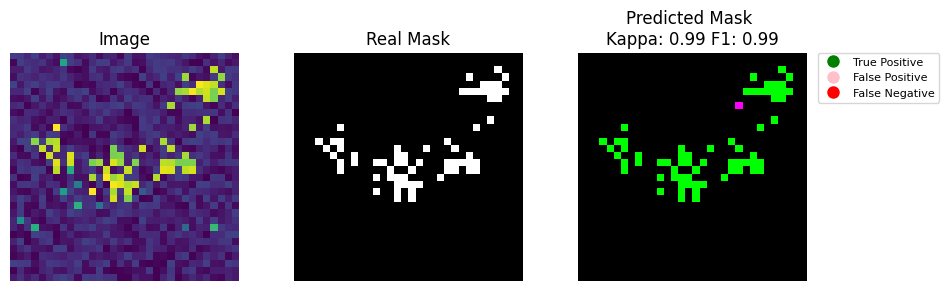

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


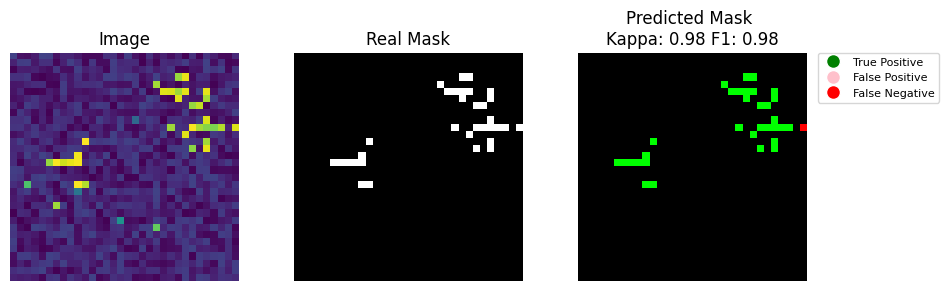

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


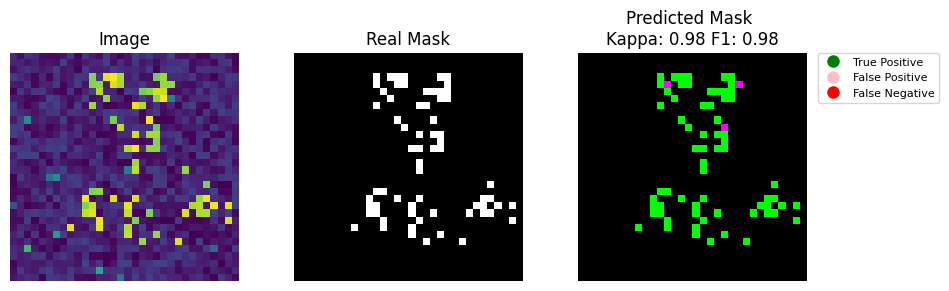

In [9]:
#Test the model on 5 images
for i in range(3):
    x_test, y_test = generate_cell_32()
    pred = model.predict(np.expand_dims(x_test, axis=0))[0]

    pred_mask = (pred[:, :, 0] > 0.5).astype(np.uint8)
    true_mask = y_test[:, :, 0]

    # Detection errors of FP
    false_positives = np.logical_and(pred_mask, np.logical_not(true_mask))
    # Detection errors of FN
    false_negatives = np.logical_and(np.logical_not(pred_mask), true_mask)

    # Create a color mask
    pred_rgb = np.zeros((32, 32, 3), dtype=np.float32)

    #Kappa cohen score
    kappa = compute_kappa(y_test, pred_mask)
    #F1 score 0.5
    tp = np.sum(pred_mask * true_mask)
    fp = np.sum(pred_mask) - tp
    fn = np.sum(true_mask) - tp

    if tp + fp + fn == 0:
        f1_score = 0  # ou 0.0 selon la convention que tu veux adopter
    else:
        f1_score = 2 * tp / (2 * tp + fp + fn)

    for i in range(32):
        for j in range(32):
            if false_positives[i, j]:
                pred_rgb[i, j] = [1, 0, 1]  # purple pour erreur
            elif false_negatives[i, j]:
                pred_rgb[i, j] = [1, 0, 0] #red pour erreur
            elif pred_mask[i, j]:
                pred_rgb[i, j] = [0, 1, 0]  # vert pour bonne prédiction
            else:
                pred_rgb[i, j] = [0, 0, 0]  # noir sinon

    # Plot
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(x_test[:, :, 0])
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Real Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_rgb)
    plt.title("Predicted Mask \nKappa: {:.2f} F1: {:.2f}".format(kappa, f1_score))
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='True Positive', markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='False Positive', markerfacecolor='pink', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='False Negative', markerfacecolor='red', markersize=10)
    ], loc="upper left",
    bbox_to_anchor=(1.05, 1),  # Add legend
    borderaxespad=0.,          
    prop={'size': 8} )
    plt.axis("off")

    plt.tight_layout()
    plt.show()


## Results and Discussion

In this simple example, the model demonstrated excellent performance in segmenting the synthetic cells, achieving **Cohen's Kappa scores ranging from 0.99 to 1.0** and **F1 scores consistently above 0.99**. This indicates that the U-Net model was able to accurately detect and distinguish individual cell instances with very few misclassifications.

To visualize the model’s performance, we displayed three sample predictions. In each predicted mask:
- **True Positives** (correct predictions) are shown in **green** (detected cells) or **black** (background),
- **False Positives** (pixels incorrectly labeled as cells) are highlighted in **pink**,
- **False Negatives** (missed cell pixels) appear in **red**.

These visualizations confirm the model’s effectiveness under controlled conditions where:
- Cell shapes are simple,
- Instances do not overlap,
- The training and test data share similar characteristics.

However, the generation procces is very simple and the size of the picture is also very small, hence this simplicity does not reflect the complexity of real biomedical images. In real scenarios, cells may overlap, vary greatly in shape and size, and appear in noisier environments. Therefore, before evaluating the model under more realistic test conditions, our next step is to improve the **training data generation**. We will introduce **clustered outliers**, making the data more ambiguous and challenging, thus forcing the model to better generalize. And we will generate image of size 256x256 instead of 32x32.



In [10]:
#funtion for generation 256x256 image with mask
def generate_cell_256():
    # Gray image
    image = np.random.randint(0, 50, size=(256, 256, 1)).astype(np.uint8)
    mask = np.zeros((256, 256, 1), dtype=np.uint8)
    num_clusters = np.random.randint(75, 200)  # Number of cells by images

    for _ in range(num_clusters):
        #Random chose of the size of the cluster
        pixels_per_cluster= int(max(1000, np.random.normal(3124, 5000)))
        #Randomly generate a cluster center
        center_x = np.random.randint(4, 252)
        center_y = np.random.randint(4, 252)

        for _ in range(pixels_per_cluster):
            dx = int(np.random.normal(0, 1))
            dy = int(np.random.normal(0, 1))
            x = np.clip(center_x + dx, 0, 255)
            y = np.clip(center_y + dy, 0, 255)

            image[x, y, 0] = np.random.randint(150, 220)  # pixel more clair (ie. clair pixel a fluorescent cell)
            mask[x, y, 0] = 1  # White pixel in the mask that corresponds to the cell

    # Generate outlier points
    outliers = np.random.randint(4000, 8000)
    for _ in range(outliers):
        x, y = np.random.randint(0, 256, size=2)
        if mask[x, y, 0] == 0:
            image[x, y, 0] = np.random.randint(50, 220)
    
    # Generate outlier clusters
    num_clusters_outlier = np.random.randint(50, 150)  # Number of clusters of outliers
    

    for _ in range(num_clusters_outlier):
        #Use normal distribution for the number of pixels per cluster d'outliers with expection 2000 and std 1000
        pixels_per_cluster_outlier= int(max(750, np.random.normal(1500, 1500)))  # Number of pixels per cluster d'outliers
   
        # Randomly generate a cluster center
        center_x = np.random.randint(4, 252)
        center_y = np.random.randint(4, 252)

        for _ in range(pixels_per_cluster_outlier):
            # Add noise gaussian around the center
            dx = int(np.random.normal(0, 1))
            dy = int(np.random.normal(0, 1))
            x = np.clip(center_x + dx, 0, 255)
            y = np.clip(center_y + dy, 0, 255)
            if mask[x, y, 0] == 0:
                image[x, y, 0] = np.random.randint(100, 185)

    return image / 255.0, mask

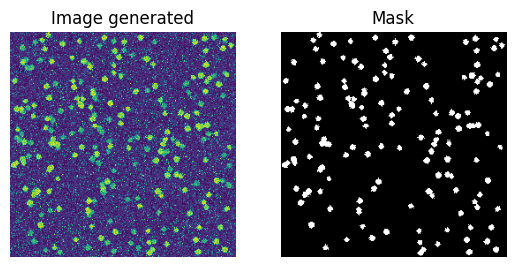

In [11]:
cell_image, cell_mask = generate_cell_256()
plt.subplot(1, 2, 1)
plt.imshow(cell_image.squeeze())
plt.title("Image generated")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cell_mask.squeeze(), cmap='gray')
plt.title("Mask")
plt.axis("off")
plt.show()

## Enhanced Image Generation

With this new generation process, the images are noticeably more complex. Some **outlier clusters** have been introduced, which can be mistaken for real cells. In our simulation, we assume that real cells are **positive fluorescent cells**, while outliers represent **non-fluorescent or irrelevant cell-like structures**.

We generate a sample of **50 images**, each of size **256x256 pixels**, using the more sophisticated generation function defined earlier. For each image:

- A **random number of cells** is created.
- Each cell is randomly positioned, shaped, and sized.
- A **variable level of noise** is added to simulate real-world imaging conditions.
- A random number of **outlier clusters** is generated.
- Each outlier cluster is randomly positioned, shaped, and sized.
- The outlier clusters are added to the image with a **lower intensity** than the cells but with the **same shape and size**.



In [12]:
#generate a dataset of 256x256 image with mask
X = []
Y = []
for _ in range(50):  # 50 exemples
    x, y = generate_cell_256()
    X.append(x)
    Y.append(y)
X = np.array(X)
Y = np.array(Y)


In [13]:

#save the dataset 
np.savez("data//dataset_train_256.npz", X=X, Y=Y)


In this part, we created the Network with the same architecture as before, but with a different input size (ie. 256x256). Hence there are more blocks in the network. The network is created with the same number of filters as before, but with a different input size. The output of the network is an binary label of size 256x256.

In [14]:
def get_unet_256():
    inputs = layers.Input((256, 256, 1))

    # Encodeur - block 1
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Encodeur - block 2
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # Decodeur - block 1
    u1 = layers.UpSampling2D((2, 2))(c3)
    concat1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    u2 = layers.UpSampling2D((2, 2))(c4)
    # Decodeur - block 2
    concat2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat2)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    return Model(inputs, outputs)


## Model Training

In this section, we train our model using **50 synthetic images** generated to simulate cell structures. We employ a **Convolutional Neural Network (CNN)** with a **U-Net architecture**, which is particularly well-suited for image segmentation tasks due to its encoder-decoder structure and skip connections.

The model is trained for **50 epochs** with a **batch size of 10**, meaning that each epoch processes the entire dataset in **5 batches**. This setup results in a total of **500 training steps** across the entire training process.

The goal of this training phase is to allow the model to learn spatial patterns and structures typical of individual cells, preparing it for accurate segmentation in the evaluation phase.


In [15]:
X_train = np.load("data//dataset_train_256.npz")["X"]
Y_train = np.load("data//dataset_train_256.npz")["Y"]
model = get_unet_256()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=50, batch_size=10, verbose=1)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8530 - loss: 0.6042
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9395 - loss: 0.3196
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9410 - loss: 0.2758
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9377 - loss: 0.2665
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9374 - loss: 0.2600
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9400 - loss: 0.2368
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9378 - loss: 0.2343
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9406 - loss: 0.2183
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9394 - loss: 0.2040
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9412 - loss: 0.1618
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9397 - loss: 0.1165
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9417 - loss: 0.0935
Epoch 13/50
5/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step

Kappa Scores: [0.9696905814215978, 0.976109143608517, 0.9629948153311718, 0.9702107899522441, 0.9683721868117651, 0.9722066312061963, 0.9644945586688671, 0.9721154129580994, 0.9770711611481877, 0.9708931122783815]
F1 Scores: [0.9715692307692307, 0.9771626297577855, 0.9643734643734644, 0.9726906158357771, 0.9711115025541659, 0.9738095238095238, 0.9667074663402693, 0.9737525987525988, 0.9790408525754885, 0.9719703215169002]

Kappa - min: 0.96, max: 0.98, mean: 0.97
F1 - min: 0.96, max: 0.98, mean: 0.97


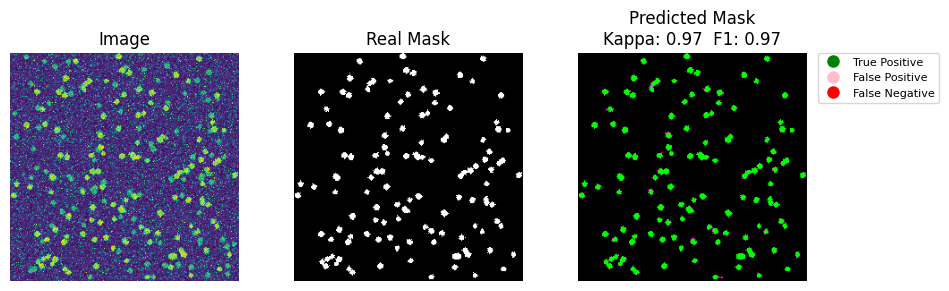

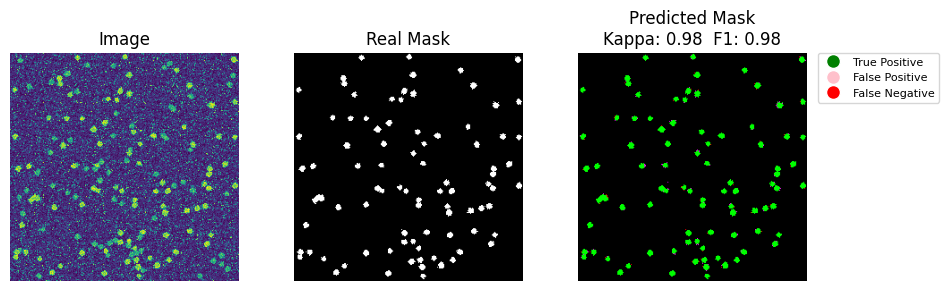

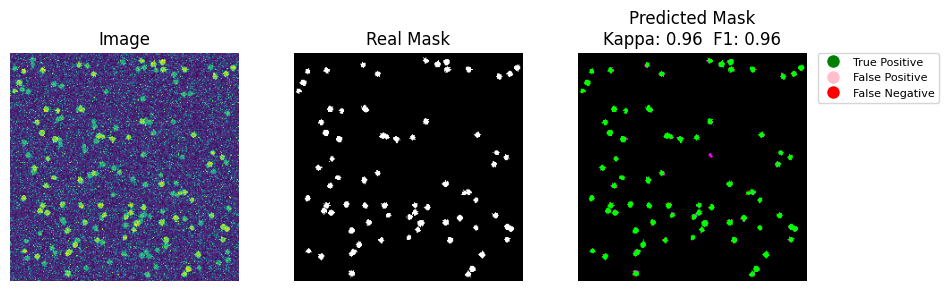

In [16]:
# Générer 10 images pour évaluer le modèle
kappa_list = []
f1_list = []

for i in range(10):
    x_test, y_test = generate_cell_256()
    pred = model.predict(np.expand_dims(x_test, axis=0))[0]

    pred_mask = (pred[:, :, 0] > 0.5).astype(np.uint8)
    true_mask = y_test[:, :, 0]

    # Calcul du score kappa
    kappa = compute_kappa(true_mask, pred_mask)
    kappa_list.append(kappa)

    # Calcul du F1 score
    tp = np.sum(pred_mask * true_mask)
    fp = np.sum(pred_mask) - tp
    fn = np.sum(true_mask) - tp
    f1_score = 2 * tp / (2 * tp + fp + fn) if (tp + fp + fn) > 0 else 0
    f1_list.append(f1_score)

    if i < 3:
        # Détection des erreurs
        false_positives = np.logical_and(pred_mask, np.logical_not(true_mask))
        false_negatives = np.logical_and(np.logical_not(pred_mask), true_mask)

        # Créer une image RGB pour affichage
        pred_rgb = np.zeros((256, 256, 3), dtype=np.float32)
        pred_rgb[false_positives] = [1, 0, 1]  # rose
        pred_rgb[false_negatives] = [1, 0, 0]  # rouge
        pred_rgb[np.logical_and(pred_mask, true_mask)] = [0, 1, 0]  # vert

        # Affichage
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(x_test[:, :, 0])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Real Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_rgb)
        plt.title(f"Predicted Mask\nKappa: {kappa:.2f}  F1: {f1_score:.2f}")
        plt.axis("off")

        # Légende
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='True Positive', markerfacecolor='green', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='False Positive', markerfacecolor='pink', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='False Negative', markerfacecolor='red', markersize=10)
        ]
        plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 8})
        plt.tight_layout()

# Résumé des scores
print(f"\nKappa Scores: {kappa_list}")
print(f"F1 Scores: {f1_list}")
print(f"\nKappa - min: {min(kappa_list):.2f}, max: {max(kappa_list):.2f}, mean: {np.mean(kappa_list):.2f}")
print(f"F1 - min: {min(f1_list):.2f}, max: {max(f1_list):.2f}, mean: {np.mean(f1_list):.2f}")


### 🔍 Results Analysis

After increasing the image size and slightly enhancing the complexity of the generation process, we still observe excellent performance from our segmentation model.

-   **F1 Score:**
    *   Ranged between 0.96 and 0.98, with an average of 0.97.

-   **Cohen’s Kappa:**
    *   Also ranged between 0.96 and 0.98, with an average of 0.97.

These scores demonstrate a high level of pixel-wise accuracy in predicting cell instances.

In addition, we visualized three prediction examples to assess qualitative performance:

-   ✅ True Positives are shown in green or black,

-   ❌ False Positives in pink,

-   ❌ False Negatives in red.

We can clearly see that false detections are minimal, reinforcing the effectiveness of our model even under more complex conditions.

### 🧪 Testing on Differently Generated Images

To further evaluate the robustness and adaptability of our model, we generate a new set of test images using a **different generation process**. This new approach introduces distinct patterns, noise levels, or cell structures that were **not present during training**:
-   The cells are less light than previously.
-   The outlier clusters are more light than previously.
-   The cells and outlier clusters are more larger (more of dispersion) than previously.
-   The cells and outlier clusters are more rare than previously.



The goal is to assess whether the model can still accurately segment the cells when exposed to **new visual contexts** or **distribution shifts**.

This step allows us to:

-   **Examine the generalization ability** of the model.
-   **Identify potential limitations** when facing unfamiliar scenarios.
-   **Prepare for more realistic applications** where the data might differ significantly from the training set.

We will once again evaluate the model using both **quantitative metrics** (F1 Score, Cohen’s Kappa) and **qualitative visualizations**.


In [18]:
def generate_cell_256_test():
    # Image in grayscale more noisy
    image = np.random.randint(10, 80, size=(256, 256, 1)).astype(np.uint8)
    mask = np.zeros((256, 256, 1), dtype=np.uint8)

    # Less clusters of cells but larger
    num_clusters = np.random.randint(30, 60)  # Moins de cellules
    for _ in range(num_clusters):
        pixels_per_cluster = int(max(2500, np.random.normal(6000, 2000)))  # Cellules plus larges
        center_x = np.random.randint(10, 246)
        center_y = np.random.randint(10, 246)

        for _ in range(pixels_per_cluster):
            dx = int(np.random.normal(0, 2))  # More dispersion
            dy = int(np.random.normal(0, 2))
            x = np.clip(center_x + dx, 0, 255)
            y = np.clip(center_y + dy, 0, 255)
            image[x, y, 0] = np.random.randint(160, 255)
            mask[x, y, 0] = 1

    # Moins d’outliers isolés
    outliers = np.random.randint(1000, 2000)
    for _ in range(outliers):
        x, y = np.random.randint(0, 256, size=2)
        if mask[x, y, 0] == 0:
            image[x, y, 0] = np.random.randint(90, 200)

    # Clusters d'outliers très dispersés
    num_clusters_outlier = np.random.randint(30, 60)
    for _ in range(num_clusters_outlier):
        pixels_per_cluster_outlier = int(max(1000, np.random.normal(3000, 1500)))  # Plus gros et plus aléatoires
        center_x = np.random.randint(10, 246)
        center_y = np.random.randint(10, 246)

        for _ in range(pixels_per_cluster_outlier):
            dx = int(np.random.normal(0, 2))  # Dispersion bien plus grande
            dy = int(np.random.normal(0, 2))
            x = np.clip(center_x + dx, 0, 255)
            y = np.clip(center_y + dy, 0, 255)
            if mask[x, y, 0] == 0:
                image[x, y, 0] = np.random.randint(100, 220)

    return image / 255.0, mask


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step

Kappa Scores: [0.8666274988927533, 0.8709047461551723, 0.9126306022184636, 0.8756020385832546, 0.8880269203847292, 0.9243674605753308, 0.9020520904172075, 0.8827559960315284, 0.9240363776732774, 0.9339558202156882]
F1 Scores: [0.8772494790680053, 0.881396860778304, 0.9220943290286356, 0.8839002267573696, 0.8977599581626428, 0.9313255005791825, 0.9119784253502135, 0.89209726443769, 0.9313948919449901, 0.9403209232471741]

Kappa - min: 0.87, max: 0.93, mean: 0.90
F1 - min: 0.88, max: 0.94, mean: 0.91


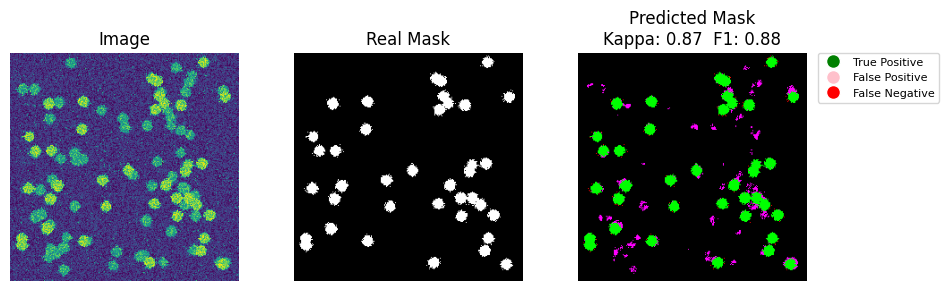

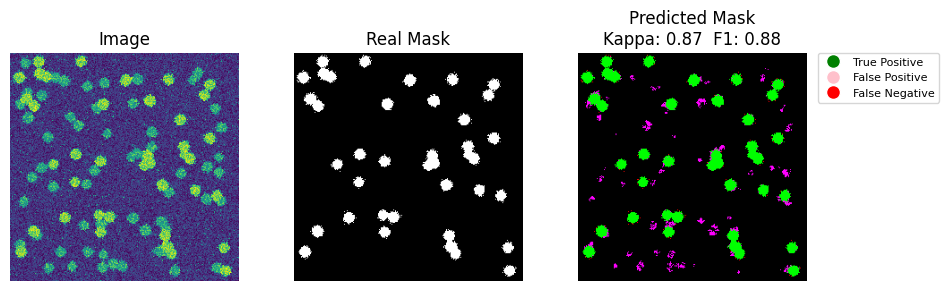

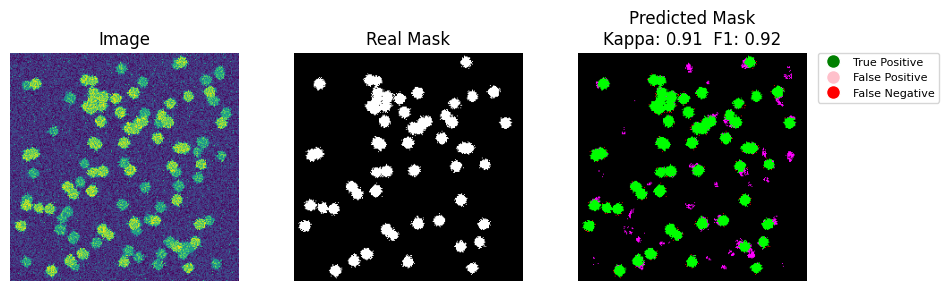

In [19]:
# Générer 10 images pour évaluer le modèle
kappa_list = []
f1_list = []

for i in range(10):
    x_test, y_test = generate_cell_256_test()
    pred = model.predict(np.expand_dims(x_test, axis=0))[0]

    pred_mask = (pred[:, :, 0] > 0.5).astype(np.uint8)
    true_mask = y_test[:, :, 0]

    # Calcul du score kappa
    kappa = compute_kappa(true_mask, pred_mask)
    kappa_list.append(kappa)

    # Calcul du F1 score
    tp = np.sum(pred_mask * true_mask)
    fp = np.sum(pred_mask) - tp
    fn = np.sum(true_mask) - tp
    f1_score = 2 * tp / (2 * tp + fp + fn) if (tp + fp + fn) > 0 else 0
    f1_list.append(f1_score)

    if i < 3:
        # Détection des erreurs
        false_positives = np.logical_and(pred_mask, np.logical_not(true_mask))
        false_negatives = np.logical_and(np.logical_not(pred_mask), true_mask)

        # Créer une image RGB pour affichage
        pred_rgb = np.zeros((256, 256, 3), dtype=np.float32)
        pred_rgb[false_positives] = [1, 0, 1]  # rose
        pred_rgb[false_negatives] = [1, 0, 0]  # rouge
        pred_rgb[np.logical_and(pred_mask, true_mask)] = [0, 1, 0]  # vert

        # Affichage
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(x_test[:, :, 0])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Real Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_rgb)
        plt.title(f"Predicted Mask\nKappa: {kappa:.2f}  F1: {f1_score:.2f}")
        plt.axis("off")

        # Légende
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='True Positive', markerfacecolor='green', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='False Positive', markerfacecolor='pink', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='False Negative', markerfacecolor='red', markersize=10)
        ]
        plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0., prop={'size': 8})
        plt.tight_layout()

# Résumé des scores
print(f"\nKappa Scores: {kappa_list}")
print(f"F1 Scores: {f1_list}")
print(f"\nKappa - min: {min(kappa_list):.2f}, max: {max(kappa_list):.2f}, mean: {np.mean(kappa_list):.2f}")
print(f"F1 - min: {min(f1_list):.2f}, max: {max(f1_list):.2f}, mean: {np.mean(f1_list):.2f}")


### 🧪 Testing on Differently Generated Images

To further evaluate the robustness and adaptability of our model, we generated a new set of test images using a **different generation strategy**. These images incorporate variations in cell shapes, noise, and spatial distribution — patterns that were **not seen during training**.

Despite these changes, the model continues to deliver **strong performance**:

- **Cohen’s Kappa:**
  - Min: **0.87**
  - Max: **0.93**
  - Mean: **0.90**

- **F1 Score:**
  - Min: **0.88**
  - Max: **0.94**
  - Mean: **0.91**

While these results remain highly satisfactory, **visual inspection** reveals an increased presence of **false positives**, represented in **pink** on the predicted masks. This suggests the model occasionally misclassifies **outlier structures as fluorescent cells**, reflecting a slight difficulty in discriminating edge cases.

Nonetheless, this test confirms that **U-Net and CNN-based architectures** maintain a **high degree of accuracy** and are a reliable choice for pixel-level segmentation tasks, even under distribution shifts.
